In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
import joblib

In [6]:
df = pd.read_csv('../data/raw/beer_reviews.csv')

In [7]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [8]:
df = df.drop(['brewery_id', 'brewery_name', 'review_profilename', 'beer_name', 'beer_beerid'], axis=1)

In [9]:
df.describe()

,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06
mean,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00
std,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00
min,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02
25%,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00
50%,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00
75%,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00
max,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01


In [10]:
def missing_prop(df):
    for column in df:
        if df[column].isna().sum()!= 0:
            print(f'Column ({column}) contain {round(100*(df[column].isna().sum()/len(df)), 4)}% missing \
            values.\n Totaling {df[column].isna().sum()} missing values')

In [11]:
missing_prop(df)

Column (beer_abv) contain 4.2723% missing             values.
 Totaling 67785 missing values


In [12]:
df['beer_abv'].fillna((df['beer_abv'].mean()), inplace=True)

In [13]:
missing_prop(df)

In [14]:
features = df.drop(['beer_style'], axis=1)
target = df['beer_style']

In [15]:
def find_outliers(df, threshold=3):
    outliers = pd.DataFrame(columns=['Column', 'Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'])
    for column in df.columns:
        data = df[column]
        mean = np.mean(data)
        std = np.std(data)
        cutoff = threshold * std
        lower_bound = mean - cutoff
        upper_bound = mean + cutoff
        column_outliers = data[(data < lower_bound) | (data > upper_bound)]
        if len(column_outliers) > 0:
            outlier_stats = pd.Series([column,
                                       len(column_outliers),
                                       mean,
                                       std,
                                       np.min(data),
                                       np.percentile(data, 25),
                                       np.median(data),
                                       np.percentile(data, 75),
                                       np.max(data)],
                                      index=outliers.columns)
            outliers = outliers.append(outlier_stats, ignore_index=True)
    return outliers

def drop_outliers(df, columns, limit=0.05):
    df_new = df.copy()
    for col in columns:
        if col in df.columns:
            df_new[col] = winsorize(df_new[col], limits=[limit, limit])
    return df_new

In [16]:
find_outliers(features)

,Column,Count,Mean,Std,Min,25%,50%,75%,Max
0,review_time,568,1.224089e+09,7.654425e+07,840672001,1.173224e+09,1.239203e+09,1.288568e+09,1326285348
1,review_overall,23936,3.815581e+00,7.206216e-01,0.0,3.500000e+00,4.000000e+00,4.500000e+00,5.0
2,review_aroma,19397,3.735636e+00,6.976165e-01,1.0,3.500000e+00,4.000000e+00,4.000000e+00,5.0
3,review_appearance,9477,3.841642e+00,6.160926e-01,0.0,3.500000e+00,4.000000e+00,4.000000e+00,5.0
4,review_palate,17919,3.743701e+00,6.822181e-01,1.0,3.500000e+00,4.000000e+00,4.000000e+00,5.0
5,review_taste,25119,3.792860e+00,7.319694e-01,1.0,3.500000e+00,4.000000e+00,4.500000e+00,5.0
6,beer_abv,16499,7.042387e+00,2.272371e+00,0.01,5.300000e+00,6.600000e+00,8.400000e+00,57.7


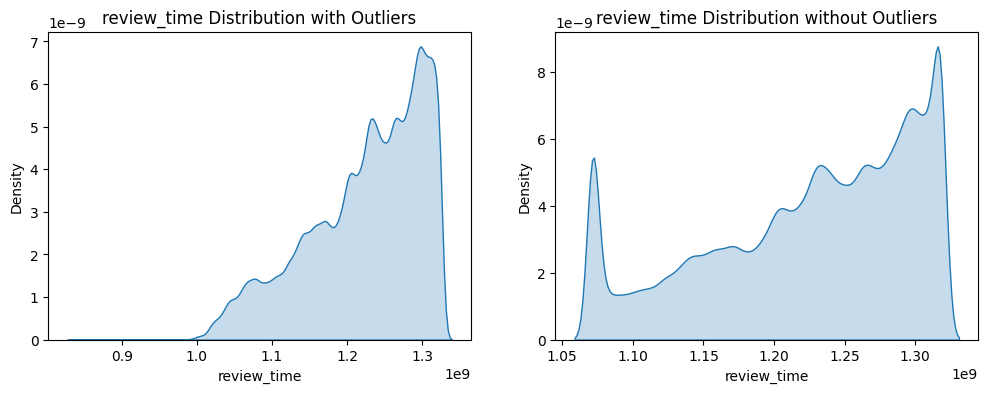

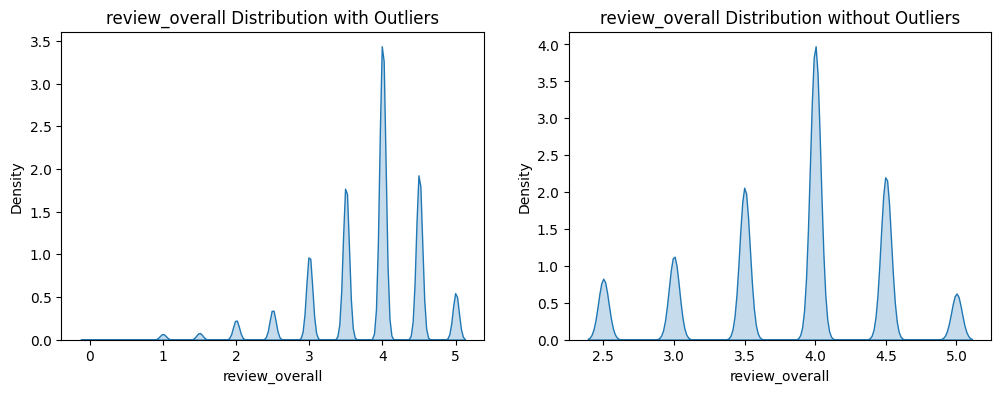

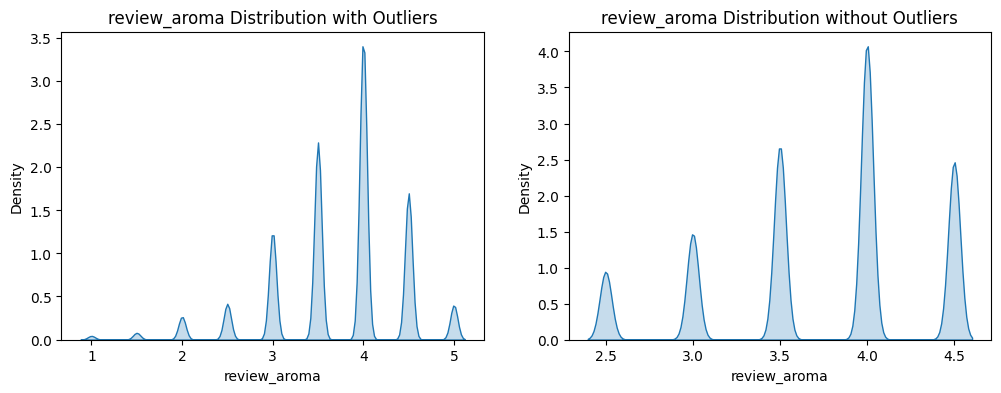

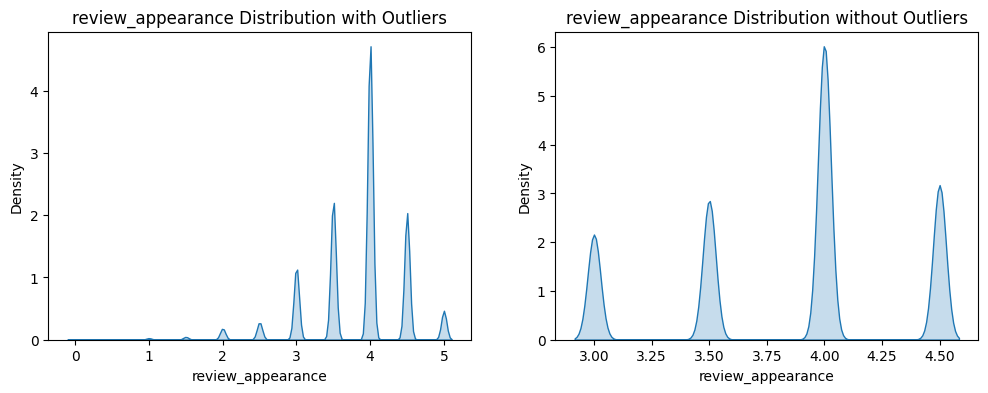

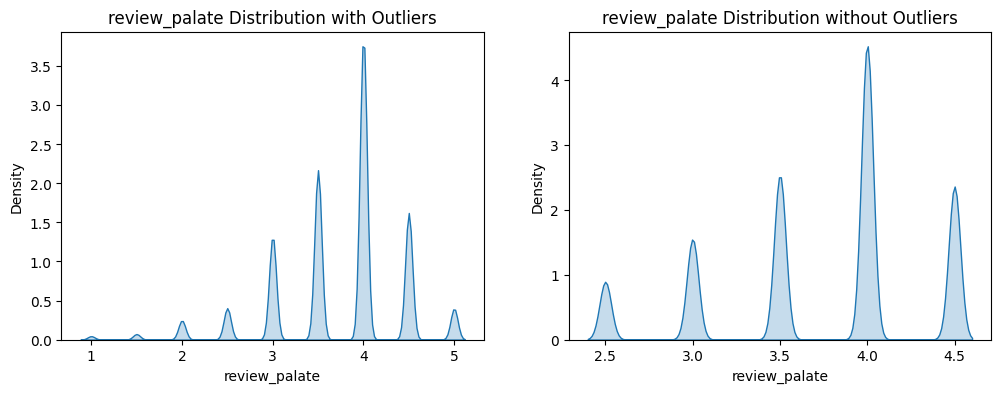

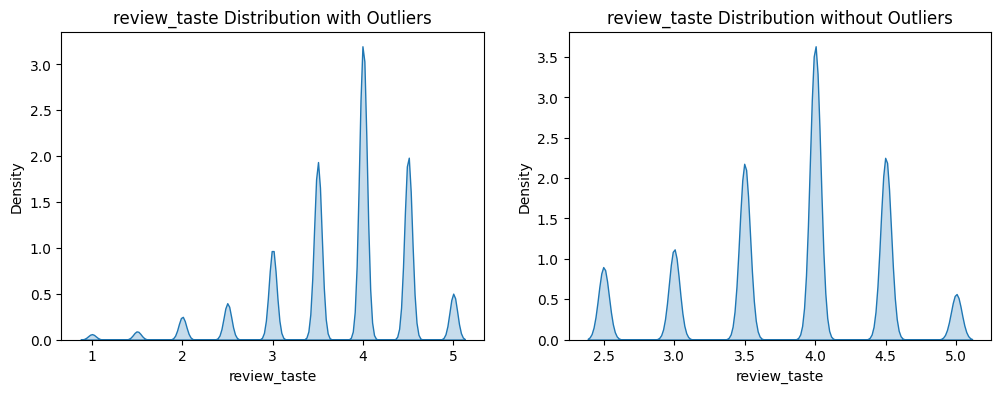

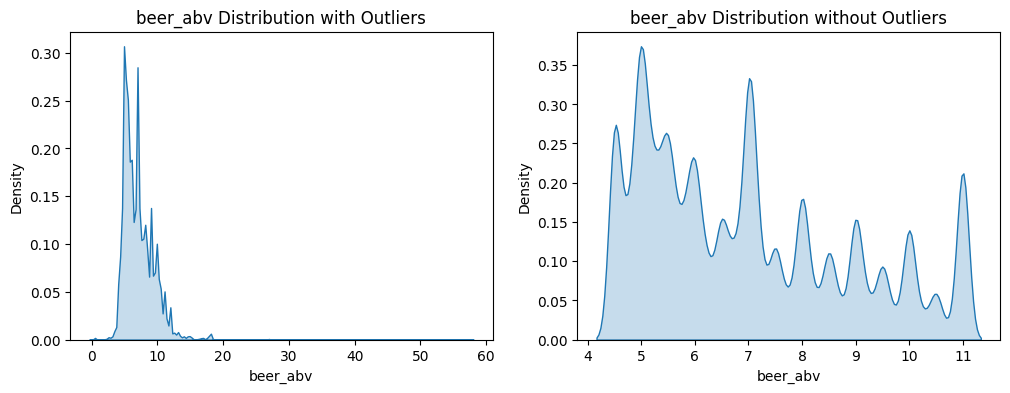

In [17]:
from scipy.stats.mstats import winsorize

out = find_outliers(features, 3)
df_new = drop_outliers(features, out['Column'])

for col in features.columns:
    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(12, 4))
    
    sns.kdeplot(x=col, data=features, ax=axes[0], shade=True)
    sns.kdeplot(x=col, data=df_new, ax=axes[1], shade=True)
    
    axes[0].set_title(col + ' Distribution with Outliers')
    axes[1].set_title(col + ' Distribution without Outliers')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target)

scaler = StandardScaler()
X = scaler.fit_transform(features)

In [25]:
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

In [28]:
joblib.dump(label_mapping, '../models/label_map')

['../models/label_map']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

In [ ]:
# Define the tuner directory
tuner_directory = 'tuner_directory/classification'

# Define the model builder function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 16, 128, 16),
                               activation='relu'))

    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])  # Add additional metrics here

    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_directory',
    project_name='classification'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(1)[0]

# Evaluate the best model on the testing set
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test F1 Score: {f1:.4f}')

# Delete the tuner directory
shutil.rmtree(tuner_directory)

In [15]:
# Define the tuner directory
tuner_directory = 'tuner_directory/classification'

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 16, 128, 16),
                               activation='relu'))
    
    model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='my_project')

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

# Retrieve the best model found
best_model = tuner.get_best_models(num_models=1)[0]

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Delete the tuner directory
shutil.rmtree(tuner_directory)

Trial 10 Complete [00h 12m 52s]
val_accuracy: 0.20557287335395813

Best val_accuracy So Far: 0.20558862388134003
Total elapsed time: 01h 09m 38s
INFO:tensorflow:Oracle triggered exit
9917/9917 [==============================] - 21s 2ms/step - loss: 3.1191 - accuracy: 0.2056
Test loss: 3.1190602779388428, Test accuracy: 0.20558862388134003


NameError: name 'shutil' is not defined

In [17]:
best_model.save('model.h5')

In [18]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               896       
                                                                 
 dense_1 (Dense)             (None, 80)                9040      
                                                                 
 dense_2 (Dense)             (None, 104)               8424      
                                                                 
Total params: 18,360
Trainable params: 18,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(f"Distribution of Categories in '{column}'")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
plot_category_distribution(df, 'beer_style')

In [ ]:
np.shape(df)